In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.coeff2header as c2h
import scipy.signal as signal
import imp # for module development and reload()
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

# IIR Filter Design

Floating point IIR filters as a cascade of second-order biquadratic sections is the objective here. We will also need a means to export the filter coefficients to header files for use in embedded systems designs. Header export functions for `float32_t` cascade of second-order sections (SOS) format are provided in the module `coeff2header.py`. The next step is to actually design some filters using functions found in `scipy.signal`. Specifically `signal.iirdesign()` serves as a design function for IIR filters from amplitude response requirements. The code module `iir_design_helper.py` contains lowpass, highpass, bandpass, and bandstop wrapper functions over `iirdesign()` to make the design process consistent with the FIR design process established in the module `fir_design_helper.py`. Understand also that `iirdesign()` itself wraps other lower level IIR filter design functions found in `scipy.signal`.

In the end the key functions to be used for the design of IIR digital filters from classical analog prototypes have their doc strings shown below:

```python
def IIR_lpf(f_pass, f_stop, Ripple_pass, Atten_stop, 
            fs = 1.00, ftype = 'butter'):
    """
    Design an IIR lowpass filter using scipy.signal.iirdesign. 
    The filter order is determined based on 
    f_pass Hz, f_stop Hz, and the desired stopband attenuation
    d_stop in dB, all relative to a sampling rate of fs Hz.

    Mark Wickert October 2016
    """
   
    b,a = signal.iirdesign(2*float(f_pass)/fs, 2*float(f_stop)/fs,
                           Ripple_pass, Atten_stop,
                           ftype = ftype, output='ba')
    sos = signal.iirdesign(2*float(f_pass)/fs, 2*float(f_stop)/fs,
                           Ripple_pass, Atten_stop,
                           ftype = ftype, output='sos')
    tag = 'IIR ' + ftype + ' order'
    print('%s = %d.' % (tag,len(a)-1))
    return b, a, sos
```


## IIR Design Based on the Bilinear Transformation
There are multiple ways of designing IIR filters based on amplitude response requirements. When the desire is to have the filter approximation follow an analog prototype such as Butterworth, Chebychev, etc., is using the bilinear transformation. The function `signal.iirdesign()` described above does exactly this.

In the example below we consider lowpass amplitude response requirements and see how the filter order changes when we choose different analog prototypes.

### Example: Lowpass Design Comparison
The lowpass amplitude response requirements given $f_s = 48$ kHz are:
1. $f_\text{pass} = 5$ kHz
2. $f_\text{stop} = 8$ kHz
3. Passband ripple of 0.5 dB
4. Stopband attenuation of 60 dB



In [3]:
fs = 48000
f_pass = 5000
f_stop = 8000
b_but,a_but,sos_but = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'butter')
b_cheb1,a_cheb1,sos_cheb1 = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'cheby1')
b_cheb2,a_cheb2,sos_cheb2 = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'cheby2')
b_elli,a_elli,sos_elli = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'ellip')

IIR butter order = 15.
IIR cheby1 order = 8.
IIR cheby2 order = 8.
IIR ellip order = 6.


### Using Frequency Response List for Cascade Designs
Similar to frequency response list for the standard rational function form of $H(z)$, but now using the cascade of second-order sections form instead of the large `a` and `b` polynomials. The tradeoff between the design is easily seen.

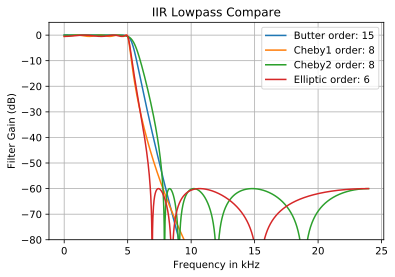

In [4]:
iir_d.freqz_resp_cas_list([sos_but,sos_cheb1,sos_cheb2,sos_elli],'dB',fs=48)
ylim([-80,5])
title(r'IIR Lowpass Compare')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Butter order: %d' % (len(a_but)-1),
        r'Cheby1 order: %d' % (len(a_cheb1)-1), 
        r'Cheby2 order: %d' % (len(a_cheb2)-1), 
        r'Elliptic order: %d' % (len(a_elli)-1)),loc='best')
grid();

#### Pole-zero Plot of Butterworth Design

(15, 15)

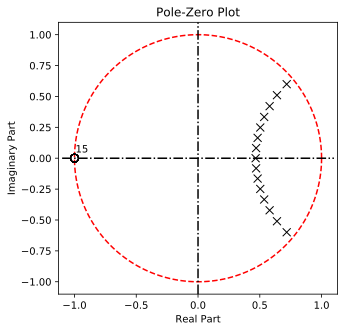

In [5]:
iir_d.sos_zplane(sos_but)

# Exporting Coefficients to Header Files
Once a filter design is complete it can be exported as a C header file using `IIR_sos_header()` for floating-point cascade of second-order sections design.

This function is available in `coeff2header.py`.

In [10]:
# Write a C header file
c2h.IIR_sos_header('IIR_elliptic_lpf_5_8.h',sos_elli)

* The header file, `remez_8_14_bpf_f32.h` written above takes the form:

```c
//define a IIR SOS CMSIS-DSP coefficient array

#include <stdint.h>

#ifndef STAGES
#define STAGES 3
#endif
/*********************************************************/
/*                     IIR SOS Filter Coefficients       */
float32_t ba_coeff[15] = { //b0,b1,b2,a1,a2,... by stage
    +3.405534e-03, +2.879634e-03, +3.405534e-03,
    +1.555966e+00, -6.373943e-01,
    +1.000000e+00, -8.884023e-01, +1.000000e+00,
    +1.525341e+00, -7.895790e-01,
    +1.000000e+00, -1.232239e+00, +1.000000e+00,
    +1.530379e+00, -9.375340e-01
};
/*********************************************************/
```

* As in the FIR design notebook, the design can be run on an ARM Cortex M4 micro controller using the [Cypress FM4](http://www.cypress.com/documentation/development-kitsboards/fm4-s6e2g-series-pioneer-kit-guide) $50 dev kit

In [7]:
# Export the Chebyshev 1 Design
c2h.IIR_sos_header('IIR_cheby1_lpf_5_8.h',sos_cheb1)

## Comparing with Measured Data
Here we use the Analog Discovery as a means to capture measured results with the original design.
### The Elliptic Design

In [8]:
f_AD,Mag_AD, Phase_AD = loadtxt('IIR_elliptic_5_8_48k.csv',
                                delimiter=',',skiprows=6,unpack=True)

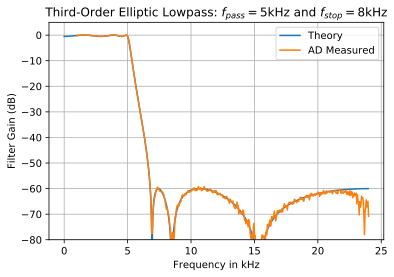

In [9]:
iir_d.freqz_resp_cas_list([sos_elli],'dB',fs=48)
ylim([-80,5])
plot(f_AD/1e3,Mag_AD)
title(r'Third-Order Elliptic Lowpass: $f_{pass}=5$kHz and $f_{stop}=8$kHz')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Theory',r'AD Measured'),loc='upper right')
grid();

### The Chebyshev Type 1 Design

In [8]:
f_AD,Mag_AD, Phase_AD = loadtxt('IIR_cheby1_5_8_48k.csv',
                                delimiter=',',skiprows=6,unpack=True)

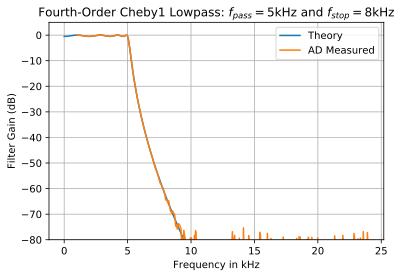

In [9]:
iir_d.freqz_resp_cas_list([sos_cheb1],'dB',fs=48)
ylim([-80,5])
plot(f_AD/1e3,Mag_AD)
title(r'Fourth-Order Cheby1 Lowpass: $f_{pass}=5$kHz and $f_{stop}=8$kHz')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Theory',r'AD Measured'),loc='upper right')
grid();

## IIR Design Problem
In this first problem you will implement a specific IIR design to meet certain amplitude response requirements. The filter topology will be a cascade of second-order sections that follows from the example given earlier in the this notebook. Design your filter to meet specific amplitude response requirements given in Figure 16, using an elliptic lowpass filter prototype.

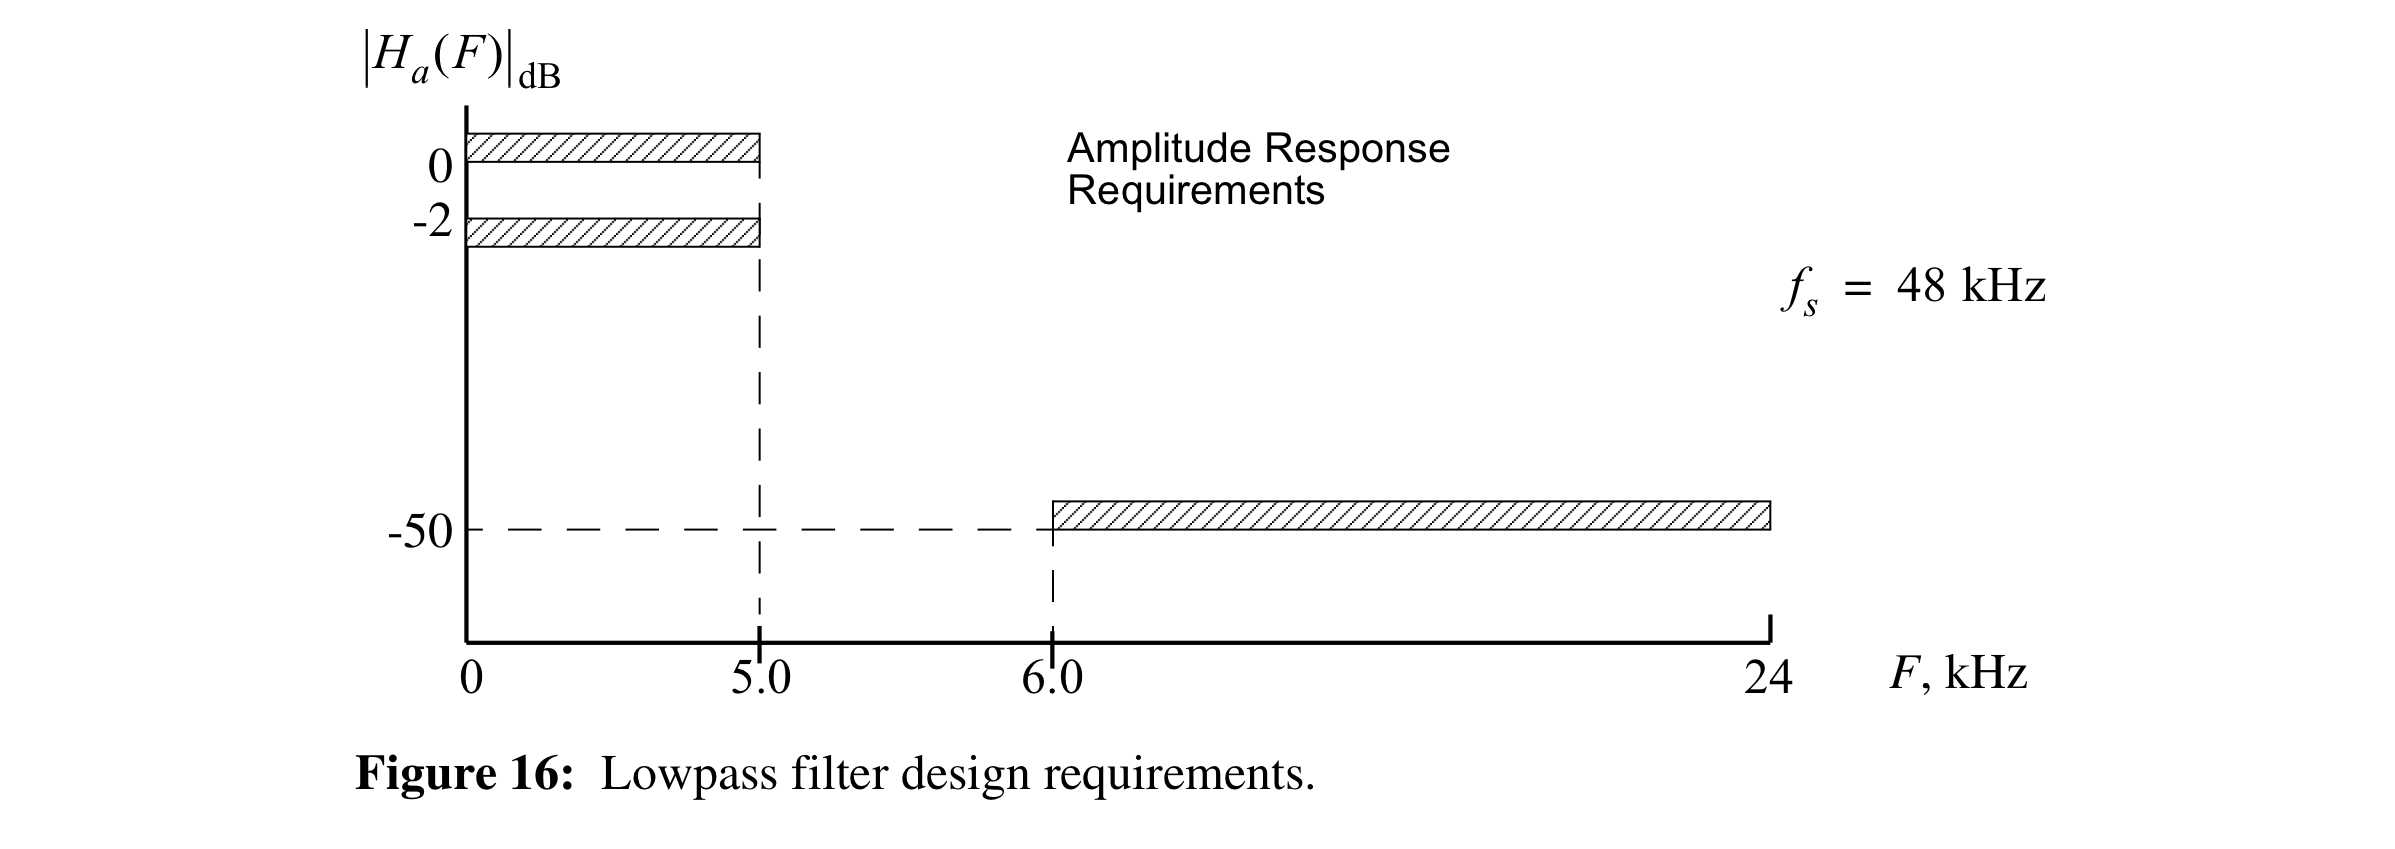

In [10]:
Image('images/IIR_LPF_Design.png',width='100%')

1. Design the filter here in the Jupyter notebook. Consider Butterworth, Chebyshev type 1 and type 2, and elliptic analog prototypes. Comment on the resulting filter orders required.

2. Compare the theoretical magnitude response in dB versus frequency in Hz using `freqz_resp_cas_list()`. By compare it means all four designs. This means in $H(z)$ when you make the substitution $z = e^{j2\pi f/f_s}$. Overlay the amplitude response design requirements.

3. Optionally take a look at the group delay of the four designs. **Hint**: Change `'dB'` to `'groupdelay_s'`

3. Plot the pole-zero pattern for the elliptic design and comment on how the geometry of the poles and zeros define the passband and the stopband locations.

**Note** We can test this filter in Lab3 using PyAudio for real-time DSP.